In [1]:
from transformers import AutoModel
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import transformers
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score,mean_absolute_error,mean_squared_error,accuracy_score,explained_variance_score,r2_score,confusion_matrix,ConfusionMatrixDisplay,classification_report,f1_score, silhouette_score,adjusted_mutual_info_score

In [2]:
device = 'cuda'
model_name = 'model/deberta-v3-large'
tokenizer_name = 'model/tokenizer/deberta-v3-large'

In [3]:
class EssaySet(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
    def __getitem__(self, index):
        essay = self.data['essay'][index]
        
        inputs = self.tokenizer.encode_plus(
            essay,
            None,
            add_special_tokens=True,
            max_length=512,    # max sequence length, default is 1024
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data['domain1_score'][index], dtype=torch.long)
        } 
    def __len__(self):
        return self.len

In [4]:
class FrozenEssayModel(nn.Module):
    def __init__(self,classnum):
        super(FrozenEssayModel,self).__init__()
        self.model_name = model_name
        self.encoder = AutoModel.from_pretrained(self.model_name)
        # this is how you freeze a model: the base_model is generic term for the transformer name
        for name,p in self.encoder.base_model.named_parameters():
            #if name.startswith('embeddings') or name.split('.')[2] in [str(i) for i in range(23)]:
            p.requires_grad = False
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self.encoder.config.hidden_size,128)
        #self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128,classnum)
        
    def forward(self,ids,mask):
        outputs = self.encoder(ids,mask, return_dict=False)[0][:, 0]
        outputs = self.dropout(outputs)
        outputs = self.fc1(outputs)
        #outputs = torch.nn.ReLU()(outputs)
        #outputs = self.dropout(outputs)
        outputs = self.fc2(outputs)
        return outputs

In [5]:
def train(epoch,model,loader):
    tr_loss = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    truel = []
    predl = []
    res = {'loss':[],'acc':[],'epoch_loss':[]}
    for _,data in enumerate(loader, 0):
        #print('{}/{}'.format(nb_tr_steps,len(training_loader)//16))
        truel += [int(i) for i in data['targets']]
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
       
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        predl += [int(i) for i in torch.max(outputs.data.detach().cpu(),dim=1)[1]]
        #print("{:.2f}".format(accuracy_score(truel,predl)))
        nb_tr_steps += 1
        print("loss: {:.2f}".format(tr_loss/nb_tr_steps))
        res['loss'].append(tr_loss/nb_tr_steps)
        if nb_tr_steps %10 == 0:
            print("acc: {:.2f}".format(accuracy_score(truel,predl)))
            res['acc'].append(accuracy_score(truel,predl))
        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()
    print('The Total Accuracy for Epoch {}: {}'.format(epoch,tr_loss/nb_tr_steps))
    res['epoch_loss'].append(tr_loss/nb_tr_steps)
    return res

def test(model,loader):
    true = []
    pred = []
    nb_tr_steps = 0
    with torch.no_grad():
        for _,data in enumerate(loader, 0):
            true += [int(i) for i in data['targets']]
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)     
            outputs = model(ids, mask)
            #outputs = nn.Softmax()(outputs)
            pred += [int(i) for i in torch.max(outputs.data.detach().cpu(),dim=1)[1]]
            #print(pred)
            nb_tr_steps += 1
    return (true,pred)

In [6]:
d = pd.read_excel('data/asap-aes/training_set_rel3.xls')
subsets = []
for i in range(1,9):
    subsets.append(d[d['essay_set']==i])

In [7]:
labels = []
for i in range(1,9):
    score2label =dict()
    label = 0
    for s in sorted(list(set((d[d['essay_set']==i]['domain1_score'])))):
        score2label[s] = label
        label += 1
    subsets[i-1]['domain1_score'] = [score2label[j] for j in subsets[i-1]['domain1_score']]
    labels.append({score2label[j]:j for j in score2label})

C:\Users\GIGA\AppData\Local\Temp\ipykernel_1384\2839795683.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsets[i-1]['domain1_score'] = [score2label[j] for j in subsets[i-1]['domain1_score']]


In [8]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
train_params = {'batch_size':12,
                'shuffle': True,
                'num_workers': 0
                }
test_params = {'batch_size': 16,
                'shuffle': False,
                'num_workers': 0
                }

In [9]:
res = []
pred = []
for i in range(8):
    train_dataset=subsets[i].sample(frac=0.75,random_state=200)
    test_dataset=subsets[i].drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)
    

    
    training_set = EssaySet(train_dataset, tokenizer)
    testing_set = EssaySet(test_dataset, tokenizer)

    training_loader = DataLoader(training_set, **train_params)
    testing_loader = DataLoader(testing_set, **test_params)

    m = FrozenEssayModel(len(labels[i]))
    m.to('cuda')

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params =  m.parameters(), lr=3e-04)

    for epoch in range(5):
        res.append(train(epoch,m,training_loader))
    
    pred.append(test(m,testing_loader))
    del m
    

loss: 2.25
loss: 2.33
loss: 2.29
loss: 2.25
loss: 2.20
loss: 2.18
loss: 2.14
loss: 2.12
loss: 2.08
loss: 2.09
acc: 0.29
loss: 2.08
loss: 2.07
loss: 2.06
loss: 2.06
loss: 2.07
loss: 2.05
loss: 2.07
loss: 2.08
loss: 2.09
loss: 2.07
acc: 0.30
loss: 2.06
loss: 2.05
loss: 2.03
loss: 2.01
loss: 2.01
loss: 1.99
loss: 1.98
loss: 1.97
loss: 1.95
loss: 1.95
acc: 0.32
loss: 1.96
loss: 1.95
loss: 1.94
loss: 1.93
loss: 1.91
loss: 1.90
loss: 1.90
loss: 1.90
loss: 1.89
loss: 1.89
acc: 0.36
loss: 1.88
loss: 1.88
loss: 1.89
loss: 1.89
loss: 1.88
loss: 1.88
loss: 1.88
loss: 1.88
loss: 1.87
loss: 1.87
acc: 0.36
loss: 1.87
loss: 1.86
loss: 1.86
loss: 1.86
loss: 1.85
loss: 1.85
loss: 1.85
loss: 1.84
loss: 1.84
loss: 1.84
acc: 0.37
loss: 1.84
loss: 1.83
loss: 1.83
loss: 1.82
loss: 1.82
loss: 1.81
loss: 1.81
loss: 1.81
loss: 1.81
loss: 1.81
acc: 0.37
loss: 1.81
loss: 1.81
loss: 1.81
loss: 1.81
loss: 1.80
loss: 1.81
loss: 1.80
loss: 1.80
loss: 1.80
loss: 1.80
acc: 0.37
loss: 1.80
loss: 1.80
loss: 1.80
loss: 1

In [ ]:
for i in pred:
    print('acc: {:.2f}, qwk: {:.2f}'.format(accuracy_score(i[0],i[1]),cohen_kappa_score(i[0],i[1],weights='quadratic')))

acc: 0.44, qwk: 0.78
acc: 0.65, qwk: 0.67
acc: 0.66, qwk: 0.70
acc: 0.73, qwk: 0.83
acc: 0.62, qwk: 0.80
acc: 0.69, qwk: 0.81
acc: 0.19, qwk: 0.82
acc: 0.22, qwk: 0.50


In [ ]:
loss = []
acc = []
epoch = []
with open('features/loss.txt','r') as f:
    d = f.readlines()[6355:6730]
    for l in d:
        if l.startswith('loss'):
            loss.append(float(l.split(':')[1]))
        elif l.startswith('acc'):
            acc.append(float(l.split(':')[1]))
        elif 'Epoch' in l:
            epoch.append(float(l.split(':')[1]))
            

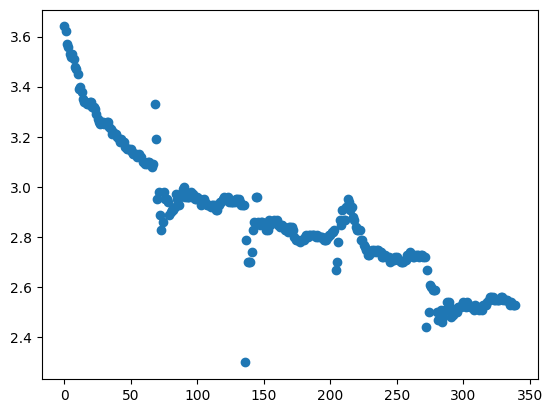

In [ ]:
plt.scatter(x=[i for i in range(len(loss))],y=loss)

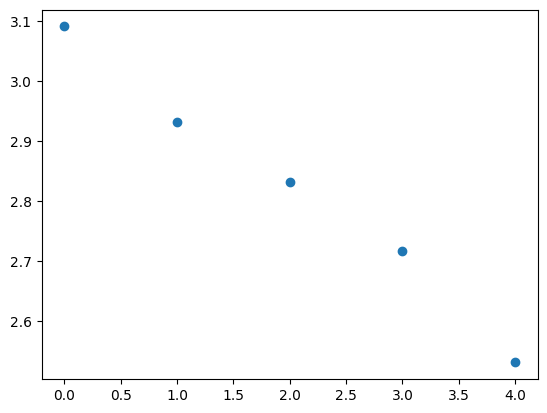

In [ ]:
plt.scatter(x=[i for i in range(len(epoch))],y=epoch)

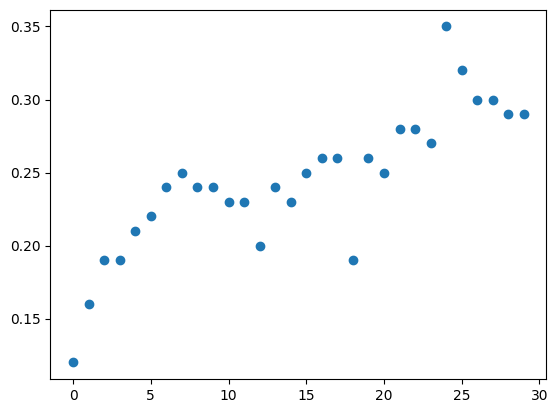

In [ ]:
plt.scatter(x=[i for i in range(len(acc))],y=acc)